<a href="https://colab.research.google.com/github/ds-joy/ML-Practice/blob/master/rice01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
! pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dsjoy36","key":"fc609c4aa58700c64c2d855a5e7eeabb"}'}

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                       title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                        Data Science Job Salaries                           7KB  2022-06-15 08:59:12          11133        354  1.0              
surajjha101/bigbasket-entire-product-list-28k-datapoints  BigBasket Entire Product List (~28K datapoints)     6MB  2022-06-22 12:51:18           3514        128  1.0              
zusmani/petrolgas-prices-worldwide                        Petrol/Gas Prices Worldwide                        10KB  2022-06-24 01:25:33           2921        126  1.0              
ramjasmaurya/1-gb-internet-price                          Internet Prices around 200+ countries in 2

In [7]:
!kaggle datasets download -d minhhuy2810/rice-diseases-image-dataset
!mkdir rice 
!unzip rice-diseases-image-dataset.zip -d rice
!rm -rf /content/rice/RiceDiseaseDataset/

Streaming output truncated to the last 5000 lines.
  inflating: rice/LabelledRice/Labelled/BrownSpot/IMG_20190424_133841.jpg  
  inflating: rice/LabelledRice/Labelled/BrownSpot/IMG_20190424_133953.jpg  
  inflating: rice/LabelledRice/Labelled/BrownSpot/IMG_20190424_133956.jpg  
  inflating: rice/LabelledRice/Labelled/BrownSpot/IMG_20190424_134124.jpg  
  inflating: rice/LabelledRice/Labelled/BrownSpot/IMG_20190424_134125.jpg  
  inflating: rice/LabelledRice/Labelled/BrownSpot/IMG_20190424_134126.jpg  
  inflating: rice/LabelledRice/Labelled/BrownSpot/IMG_20190424_134128.jpg  
  inflating: rice/LabelledRice/Labelled/BrownSpot/IMG_20190424_134129.jpg  
  inflating: rice/LabelledRice/Labelled/BrownSpot/IMG_20190424_134130.jpg  
  inflating: rice/LabelledRice/Labelled/BrownSpot/IMG_2992.jpg  
  inflating: rice/LabelledRice/Labelled/BrownSpot/IMG_2993.jpg  
  inflating: rice/LabelledRice/Labelled/BrownSpot/IMG_2998.jpg  
  inflating: rice/LabelledRice/Labelled/BrownSpot/IMG_2999.jpg  
  inf

In [8]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [9]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/rice/LabelledRice/Labelled",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3355 files belonging to 4 classes.


In [11]:
class_names = dataset.class_names
print(class_names)
print(len(dataset))

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']
105


(32, 256, 256, 3)
[1 1 3 3 1 1 1 1 3 3 1 1 1 1 1 0 2 1 3 1 1 0 1 1 1 1 1 3 2 3 1 3]
first image
(256, 256, 3)


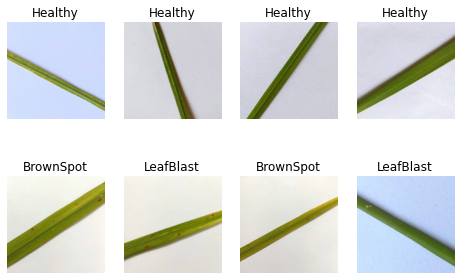

In [12]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print("first image")
    print(image_batch[0].shape)

# visualization
plt.figure(figsize=(8, 8))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")




In [13]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

84
10
11


In [16]:
# runtime optimization
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
# image preprocessing

# rescaling
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [18]:
#data_augmentation

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
# model training

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=200,
)

Epoch 1/200
84/84 [==============================] - 297s 2s/step - loss: 1.3027 - accuracy: 0.4350 - val_loss: 1.3186 - val_accuracy: 0.4313
Epoch 2/200
84/84 [==============================] - 22s 265ms/step - loss: 1.2912 - accuracy: 0.4394 - val_loss: 1.2826 - val_accuracy: 0.4313
Epoch 3/200
84/84 [==============================] - 23s 272ms/step - loss: 1.2678 - accuracy: 0.4480 - val_loss: 1.2357 - val_accuracy: 0.4656
Epoch 4/200
84/84 [==============================] - 22s 266ms/step - loss: 1.1800 - accuracy: 0.5002 - val_loss: 1.1812 - val_accuracy: 0.5031
Epoch 5/200
84/84 [==============================] - 23s 268ms/step - loss: 1.1669 - accuracy: 0.5110 - val_loss: 1.1925 - val_accuracy: 0.4750
Epoch 6/200
84/84 [==============================] - 23s 272ms/step - loss: 1.1455 - accuracy: 0.5188 - val_loss: 1.1399 - val_accuracy: 0.5094
Epoch 7/200
84/84 [==============================] - 22s 262ms/step - loss: 1.1505 - accuracy: 0.5136 - val_loss: 1.1333 - val_accuracy: 0

In [24]:
score = model.evaluate(test_ds)

11/11 [==============================] - 134s 36ms/step - loss: 0.4542 - accuracy: 0.8466


In [25]:
score

[0.45417535305023193, 0.8465909361839294]

In [26]:
model.save

<bound method Model.save of <keras.engine.sequential.Sequential object at 0x7fe774039850>>

In [27]:
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 200, 'steps': 84}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

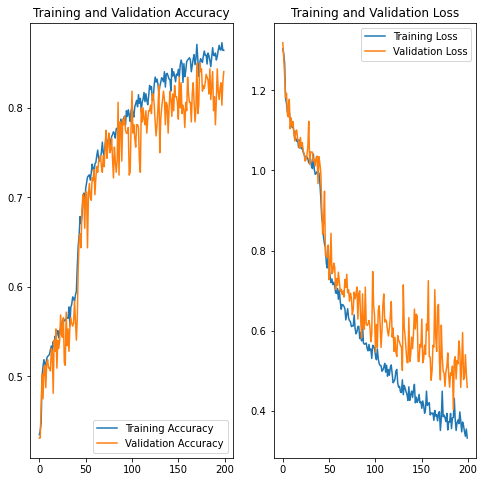

In [29]:
EPOCHS = 200
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
# Write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

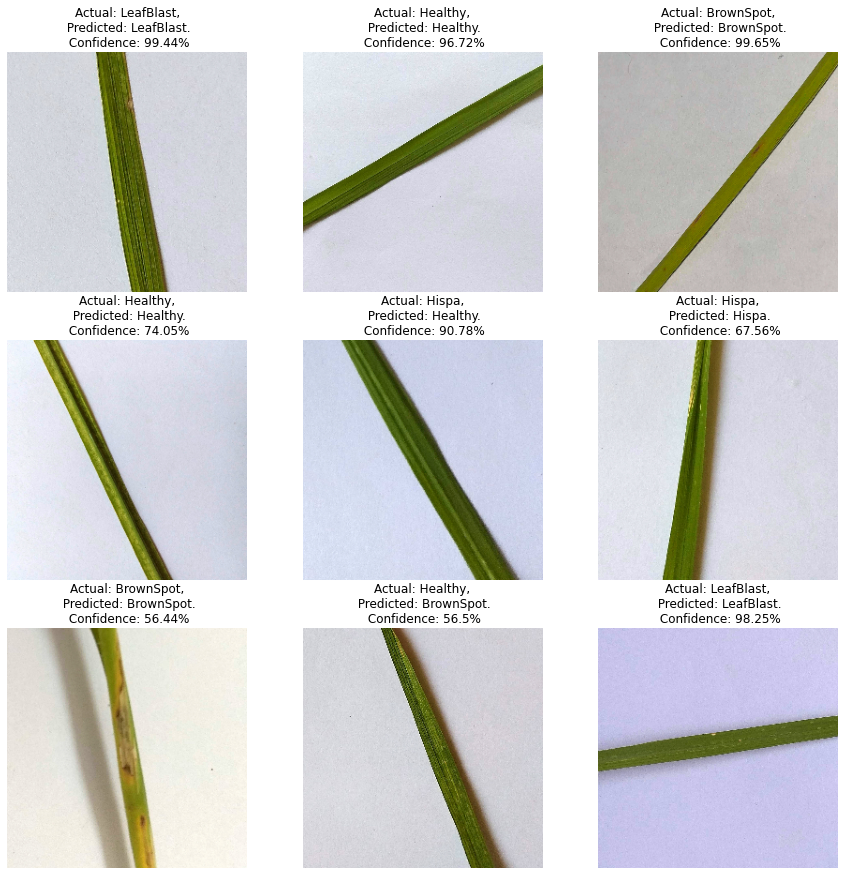

In [31]:
# Now run inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
        